# House Pricing（房价预测模型）

## 项目背景
#### 数据来源
* 项目数据基于kaggle数据集。下载地址：https://www.kaggle.com/c/house-prices-advanced-regression-techniques

#### 项目目的
* 通过训练集中79个特征变量构建房价预测模型，预测测试集中的房价。
* kaggle通过计算预测值与实际值之间的差异（损失）进行打分并排名。

# 1.导入相关基本库

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm, skew

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette() #设置图表整体格式
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #设置显示格式

# 2.读取数据并理解

In [ ]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train.columns

In [ ]:
df_train.head()

In [ ]:
df_test.head()

In [ ]:
df_train.shape,df_test.shape

* 因为变量较多，相比挨个变量进行分析，不如用pandas_profiling生成报告，对全部数据初步探索。

In [ ]:
# 删除Id
df_train.drop("Id", axis = 1, inplace = True)
df_test.drop("Id", axis = 1, inplace = True)
df_train.shape,df_test.shape

In [ ]:
# 生成可视化报告
import pandas_profiling
report = all_data.profile_report()# 这一步时间可能比较长，可以先休息一下
report.to_file(output_file='house_pricing_description_report.html')

从这份丰富的报告中可以得知：
* **变量类型**：
    * 分类变量：46个
    * 数值变量：32个（不含因变量）
    * 布尔变量：1个,CentralAir(是否有中央空调）
--------------------------------------------------------------------------------------------------------------------------------
* **含缺失值变量**：
    * 缺失率超过15%：'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage'
    * 缺失率低于15%：'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageType','BsmtExposure', 'BsmtCond', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1', 'MasVnrType', 'MasVnrArea', 'MSZoning', 'Functional', 'BsmtHalfBath', 'BsmtFullBath', 'Utilities', 'SaleType', 'BsmtFinSF1', 'KitchenQual', 'GarageCars', 'BsmtUnfSF', 'TotalBsmtSF', 'Exterior2nd', 'Exterior1st','GarageArea', 'BsmtFinSF2'
--------------------------------------------------------------------------------------------------------------------------------
* **数据理解**：
    * 数据集中共含有79个特征变量，特征较多，需要充分理解特征与因变量之间的相关性以及特征代表的意义。
    * 对缺失值进行填充应充分考虑特征代表的意义，如'PoolQC'代表泳池质量，Nan值应该表示的是“无泳池”。
    * 部分特征之间存在关联性，如'TotalBsmtSF' = 'BsmtFinSF1'+'BsmtFinSF2'+'BsmtUnfSF'，可以以此为依据，创建新变量。
    * 数据集中有部分分类变量被错误分成了数值变量，应进行类型矫正。

# 3.数据探索与处理

* 因变量的偏度得到了纠正,更趋于正态分布了。

## 3.1.变量相关性分析

In [ ]:
# 我们先来看一下线性相关系数图（不包含object类型）
corrmatrix = df_train.corr()
plt.figure(figsize=(16, 16))
sns.heatmap(corrmatrix, vmax=.8, square=True)

我们可以明显看到一些白色的格子，说明以下变量两两线性相关性强：
* TotalBsmtSF和1stfirSFm
* GrLivArea & TotRmsAbvGrid
* GarageCars & GarageArea
* YearBuilt & GarageYrblt
* Overallqual & SalePrice

可以看出来Overallqual和因变量密切相关。

In [ ]:
# 我们来看一下因变量和特征的相关性
np.abs(corrmatrix['SalePrice']).sort_values(ascending=False).head(11)

从这个分析，我们可以明显看出：
* 这10个特征和因变量密切相关，特别是OverallQual、GrLivArea、GarageCars、GarageArea、TotalBsmtSF、1stFlrSF。其中，根据上文的分析，我们知道GarageArea和GarageCars、TotalBsmtSF和1stFlrSF密切相关，因此，为避免线性回归中的多重共线性，可能需要删除其中一个变量。
* 通过分析这10个特征和因变量的散点图，我们可以初步判断因变量是否存在特别异常的值。

In [ ]:
# 通过散点矩阵判断是否有异常值
col = np.abs(corrmatrix['SalePrice']).sort_values(ascending=False).head(10).index.values
sns.pairplot(df_train[col])

我们可以看出来:
* SalePrice & GrLivArea的散点图中存在1个游离点。
* SslePrice & TotalBsmtSF、1stfirSFm的散点图中分别存在1个游离点。
* SalePrice & GarageArea的散点图中貌似存在4个游离点，但&GarageCars图中却表现较为正常，故不做删除。

因此，我们删除以上提到的3个游离点以减少异常值影响。

In [ ]:
print(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<300000)].index)
print(df_train[(df_train['TotalBsmtSF']>5000) & (df_train['SalePrice']<200000)].index)

* 看样子我们只需要删除2个游离点，索引为523和1298。

In [ ]:
df_train.drop(labels=[523,1298],axis=0,inplace=True)

# 我们来确认一下是否删除正确
plt.scatter(df_train['GrLivArea'],df_train['SalePrice'])

## 3.2.因变量正态性分析

In [ ]:
# 我们通过以下图性来看一下因变量的正态性

plt.figure(figsize=(8, 4))

# 画出直方图、Kde图和正态图
plt.subplot(121)
sns.distplot(df_train['SalePrice'] , fit=norm)
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

(mu, sigma) = norm.fit(df_train['SalePrice'])
skew = df_train['SalePrice'].skew()
kurtosis = df_train['SalePrice'].kurtosis()
print( 'mu = {:.2f},sigma = {:.2f},skew = {:.2f},kurtosis = {:.2f}'.format(mu, sigma,skew,kurtosis))

# 画出QQ图
plt.subplot(122)
qq = stats.probplot(df_train['SalePrice'], plot=plt)
plt.show()

* 可以看出，因变量是明显的右偏分布。
* 为提高模型的性能，我们需要对这个变量进行转换，使其更符合正态分布。

mu = 12.02,sigma = 0.40,skew = 0.12,kurtosis = 0.80


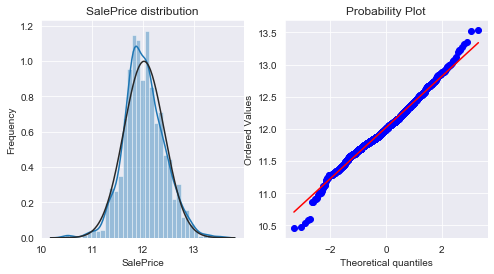

In [280]:
# 使用log(1+x)进行转换
y_train = np.log1p(df_train["SalePrice"])

# 我们来重新看一下分布图
plt.figure(figsize=(8, 4))

# 画出直方图、Kde图和正态图
plt.subplot(121)
sns.distplot(y_train , fit=norm)
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

(mu, sigma) = norm.fit(y_train)
skew = y_train.skew()
kurtosis = y_train.kurtosis()
print( 'mu = {:.2f},sigma = {:.2f},skew = {:.2f},kurtosis = {:.2f}'.format(mu, sigma,skew,kurtosis))

# 画出QQ图
plt.subplot(122)
qq = stats.probplot(y_train, plot=plt)
plt.show()

## 3.3.缺失值处理

In [ ]:
# 我们将训练集和测试集进行合并
all_data = pd.concat((df_train.iloc[:,:-1], df_test)).reset_index(drop=True)
all_data.shape

In [ ]:
# 计算缺失率
percent = all_data.apply(lambda x: np.sum(x.isnull())/len(x),axis=0)
quantity = all_data.isnull().sum()
types = all_data.dtypes
nunique = all_data.nunique()

missing_values = pd.concat([quantity, percent, types,nunique], axis=1, keys=['quantity', 'percent','type', 'nunique']).sort_values('quantity',ascending=False)
print('一共{}个特征含有缺失值'.format(missing_values[missing_values['quantity']!=0].shape[0]))
missing_values[missing_values['quantity']!=0]

* 看来缺失值很多，我们慢慢来处理吧~

1）PoolQC：数据集中与Pool有关的特征有两个，分别是PoolArea(泳池面积)和PoolQC(泳池质量)，PoolQC的数据缺失率达99%，会不会是因为房子里没有泳池呢？我们来验证一下假设。

In [ ]:
PoolQC_nan = all_data['PoolQC'].isnull()
PoolQC_nan = PoolQC_nan[PoolQC_nan==1].index.values
all_data['PoolArea'][PoolQC_nan].value_counts()

* 2905个房子确实是没有泳池的，但是也出现了3个泳池。
* 说明有三个房子明明有泳池，但缺失了PoolQC这个特征。
* 因为PoolQC的有效值只有9个，参考价值太少，故放弃填充这三个空白，删除该特征。

In [ ]:
all_data.drop('PoolQC',axis=1,inplace=True)

2）MiscFeature：指其他类别中未涉及的房子特性，如电梯、二楼花园等，与其相关的特征是MiscVal（杂项价值，以美元计）。同样，MiscFeature的数据缺失会不会是因为房子没有其他特性呢？我们来验证一下假设。

In [ ]:
MiscFeature_nan = all_data['MiscFeature'].isnull()
MiscFeature_nan = MiscFeature_nan[MiscFeature_nan==1].index.values
all_data['MiscVal'][MiscFeature_nan].value_counts()

In [ ]:
all_data[['MiscFeature','MiscVal']].groupby('MiscFeature').agg([np.max,np.size])

* 同样,有一个房子的MiscVal为17000，但缺失了MiscFeature。
* 通过对两者分布的分析，决定填充该空格为“Gar2”。

In [ ]:
all_data["MiscFeature"].fillna("None",inplace=True)
Mis_index = all_data[all_data['MiscVal']==17000].index
all_data["MiscFeature"][Mis_index] = 'Gar2'

3）Alley：指到达房子的小路类型，缺失率达93%，但无相关其他特征。因此，我们不考虑删除特征，填充缺失值为“No alley access”。

In [ ]:
all_data["Alley"].fillna("None",inplace=True)

4）Fence：指房子的围栏质量，缺失率达80%，但无相关其他特征。因此，我们不考虑删除特征，填充缺失值为“No Fence”。

In [ ]:
all_data["Fence"].fillna("None",inplace=True)

5）FireplaceQu：指房子的壁炉质量，与之相关的特征有Fireplaces（壁炉数量）。FireplaceQu的数据缺失是不是因为没有壁炉呢？我们来验证一下。

In [ ]:
FireplaceQu_nan = all_data['FireplaceQu'].isnull()
FireplaceQu_nan = FireplaceQu_nan[FireplaceQu_nan==1].index.values
all_data['Fireplaces'][FireplaceQu_nan].value_counts()

* 谢天谢地，这次我们终于猜对了，那我们把nan值填充为“No Fireplace”吧！

In [ ]:
all_data["FireplaceQu"].fillna("None",inplace=True)

6）LotFrontage：指房子和街道的线性距离，缺失率为16%，猜测该特征和房子所在社区有关，我们来看一下两者的关系。

In [ ]:
all_data[['LotFrontage','Neighborhood']].groupby('Neighborhood').agg([np.mean,np.median,np.size])

* 可以看出来，不同社区到街道的距离确实存在差异，且中位数和平均值相差不大，说明距离分布比较均匀。因此，我们使用中位数进行缺失值填充。

In [ ]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].apply(lambda x: x.fillna(x.median()))

7）GarageYrBlt, GarageFinish, GarageQual, GarageCond, GarageType, GarageCars, GarageArea：都是跟房子花园有关的特征，其中GarageCars和GarageArea各仅有1个缺失值。其余的缺失值分别为157和159。以GarageArea为引，我们来看看其他特征如何补充缺失值吧。

In [ ]:
GarageArea_zero = all_data[all_data['GarageArea']==0].index
print('GarageArea为0的个数为：',len(GarageArea_zero))
all_data.loc[GarageArea_zero,['GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageType', 'GarageCars']].describe(include='all')

* 可以看出来，当GarageArea为0时，GarageCars也全部为0，其余特征全部为nan值，因此，我们可以确定其余特征的缺失值为“No garage”。
* 但是，有的特征缺失值不只157个，我们来看看有哪些漏网之鱼。

In [ ]:
GarageYrBlt_nan = all_data['GarageYrBlt'].isnull()
GarageYrBlt_nan = GarageYrBlt_nan[GarageYrBlt_nan==1].index.values
all_data.loc[GarageYrBlt_nan,['GarageYrBlt', 'GarageFinish', 'GarageQual', 
                              'GarageCond', 'GarageType', 'GarageCars','GarageArea']].describe(include = 'all')

In [ ]:
temp = all_data.loc[GarageYrBlt_nan,['GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 
                                     'GarageType', 'GarageCars','GarageArea']]
temp [temp['GarageType']=='Detchd']

* 除了GarageType有2个是“Detchd（和房子脱离）”之外，其余都是nan值，除了这两个数据，其余都可以确定是“No Garage”。
* 这两个数据都位于测试集上，不影响我们训练模型，因此，忽略这两个数据，我们全部填充为“No Garage”。

In [ ]:
# 分类变量填充为“None”
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col].fillna('None',inplace=True)
# 数值变量填充为“0”
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col].fillna(0,inplace=True)

* 上文我们提及GarageArea, GarageCars的相关性很高，为避免多重共线性，删除其中之一。
* 因为GarageCars和因变量的相关系数更高，故删除GarageArea。

In [ ]:
all_data.drop('GarageArea',axis=1,inplace=True)

8）BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, BsmtHalfBath, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2：这些都是跟地下室有关的特征，其中BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF等4个面积特征仅有1个缺失值，以TotalBsmtSF（地下室全部面积）为引，来看一下他们的缺失值分布。

In [ ]:
TotalBsmtSF_zero = all_data[all_data['TotalBsmtSF']==0].index
print('TotalBsmtSF为0的个数为：',len(TotalBsmtSF_zero))
all_data.loc[TotalBsmtSF_zero,['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','BsmtFullBath',
                              'BsmtHalfBath', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
                              'BsmtFinType1', 'BsmtFinType2']].describe(include = 'all')

* 可以看出来，当TotalBsmtSF为0时，其余特征全部为nan值或0值，因此，我们可以确定其余特征的缺失值为“No Bsmt”。
* 不过，有关地下室的特征缺失率最高的是BsmtExposure和BsmtCond，来看看是否还有缺失值。

In [ ]:
BsmtExposure_nan = all_data['BsmtExposure'].isnull()
BsmtExposure_nan = BsmtExposure_nan[BsmtExposure_nan==1].index.values

BsmtCond_nan = all_data['BsmtCond'].isnull()
BsmtCond_nan = BsmtCond_nan[BsmtCond_nan==1].index.values

all_data.loc[np.union1d(BsmtCond_nan,BsmtExposure_nan),['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','BsmtFullBath',
                              'BsmtHalfBath', 'BsmtQual', 'BsmtCond', 'TotalBsmtSF','BsmtExposure',
                              'BsmtFinType1', 'BsmtFinType2']].describe(include = 'all')

In [ ]:
temp = all_data.loc[np.union1d(BsmtCond_nan,BsmtExposure_nan),['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','BsmtFullBath',
                                                               'BsmtHalfBath', 'BsmtQual', 'BsmtCond', 'TotalBsmtSF','BsmtExposure',
                                                               'BsmtFinType1', 'BsmtFinType2']]
temp [temp['TotalBsmtSF']!=0].dropna(how='all')

* 从中可以看出，除了有6个特殊数据，其余缺失值都可以确认为“No Bsmt”。
* 这6个数据是拥有地下室的房子，但部分BsmtExposure和BsmtCond的值缺失，因此采用众数填充。

In [ ]:
# 分类变量填充为“None”
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col].fillna('None',inplace=True)
    
# 数值变量填充为0
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col].fillna(0,inplace=True)

# 为BsmtExposure和BsmtCond填充众数
all_data['BsmtExposure'][[947,1485,2346]] = all_data['BsmtExposure'].mode()[0] #众数：No Exposure
all_data['BsmtCond'][[2038,2183,2522]] = all_data['BsmtCond'].mode()[0] #众数：Typical

9）MasVnrArea, MasVnrType：指房子的表面砌体类型和面积，没有其他相关特征，我们来看一下缺失情况。

In [ ]:
MasVnrArea_nan = all_data[all_data['MasVnrArea'].isnull()]['MasVnrType']
MasVnrType_nan = all_data[all_data['MasVnrType'].isnull()]['MasVnrArea']

print(MasVnrArea_nan.dropna())
print("-"*20)
print(MasVnrType_nan.dropna())

* 可得知，除了1个数据外，其余数据都是同时缺失这两个值。
* 同时缺失的数据，我们填充为“no Masonry”；缺失MasVnrType的数据，填充众数(除去none）。

In [ ]:
all_data["MasVnrType"].fillna("None",inplace=True)
all_data["MasVnrArea"].fillna(0,inplace=True)

# 填充缺失MasVnrType的数据
all_data['MasVnrType'][2608] = 'BrkFace' # 众数：BrkFace

10）MSZoning：指房子所属的销售分区，包括农田区、商圈区、工业区等。一般房子的销售分区和社区的关系密切，我们来看一下两者关系。

In [ ]:
plt.scatter(all_data['MSZoning'].dropna(),
            all_data['Neighborhood'][all_data['MSZoning'].dropna().index],
            alpha=0.05)
plt.show()

* 可以看出来，一般一个街区会对应1-2个销售分区，因此，我们用社区对应众数填充。

In [ ]:
all_data[['MSZoning','Neighborhood']][all_data['MSZoning'].isnull()]

In [ ]:
print(all_data['MSZoning'][all_data['Neighborhood']=='IDOTRR'].mode())
print('-'*20)
print(all_data['MSZoning'][all_data['Neighborhood']=='Mitchel'].mode())

In [ ]:
# 填充缺失值
all_data['MSZoning'].fillna('RM',inplace=True)
all_data['MSZoning'][2902] = 'RL'

11）Utilities：指可用的公共设备，无其他相关特征。我们来看一下数据分布。

In [ ]:
all_data['Utilities'].value_counts()

In [ ]:
all_data['Utilities'][all_data['Utilities'].isnull()]

* 可以了解到该特征大部分值为AllPub，只有1个NoSeWa和2个nan值，且nan值位于测试集。
* 因此，该特征对于模型构建影响非常小，我们直接删除即可。

In [ ]:
all_data.drop(['Utilities'], axis=1, inplace=True)

12）Functional：指房子的住宅功能，变量说明文件中提及住宅功能默认Typical，因此我们填充缺失值为Typical。

In [ ]:
all_data["Functional"].fillna("Typ",inplace=True)

13）Electrical：指房子的电力系统，只有1个缺失值，我们用众数填充。

In [ ]:
all_data['Electrical'].fillna(all_data['Electrical'].mode()[0], inplace=True)

14）KitchenQual：指房子的厨房质量，只有1个缺失值，我们用众数填充。

In [ ]:
all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0], inplace=True)

15）Exterior1st, Exterior2nd：指房屋外部覆盖的材料，也是只有一个缺失值,而且是同一个数据，和上面一样，我们用众数填充。

In [ ]:
all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0], inplace=True)
all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0], inplace=True)

16）SaleType：指房子的销售类型，只有1个缺失值，也是用众数填充即可。

In [ ]:
all_data['SaleType'].fillna(all_data['SaleType'].mode()[0],inplace = True)

17）MSSubClass：指房屋类型，也是众数填充。

In [ ]:
all_data['MSSubClass'].fillna("None", inplace=True)

* 终于把缺失值处理完了，我们来检查一下。

In [ ]:
all_data.isnull().sum().value_counts()

* 缺失值终于处理完毕！

## 3.4.分类变量转换

* 在前文数据探索中，我们发现部分分类变量被定义成了数值变量。因此，需要将这部分变量进行转换。

In [ ]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

* 对分类变量进行编码处理

In [ ]:
# 看看有哪些分类变量
dtype = pd.DataFrame(all_data.dtypes,columns=['types'])
dtype[dtype['types']==all_data.dtypes.unique()[0]].index

In [ ]:
# 编码处理
from sklearn.preprocessing import LabelEncoder

col = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallCond', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'Fence',
       'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']

for c in col:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

In [ ]:
# Onehot编码（排除bool类型）
from sklearn.preprocessing import OneHotEncoder

col_1 = ['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LandContour',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallCond', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'Fence',
       'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']

all_data_onehot = all_data[col_1]

onehot = OneHotEncoder(categories='auto',drop = 'first') 
all_data_onehot = onehot.fit_transform(all_data_onehot).toarray()

all_data_onehot.shape

## 3.5.构建特征组合

* 根据已有的数值特征，我们可以构建新的特征组合。

In [ ]:
# 增加房屋总面积
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [ ]:
# 增加浴室总数量
all_data['TotalBath'] = all_data['BsmtFullBath'] + all_data['BsmtHalfBath'] + all_data['FullBath']+all_data['HalfBath']

## 3.6.数值特征正态化

In [269]:
# 创建数值数据集
all_data_num = all_data.copy()
for c in col_1:
    all_data_num = all_data_num.drop(labels = c,axis=1)
    
# 创建布尔数据集
all_data_bool = all_data[['Street','CentralAir']]

#得到最终的数值特征数据集
all_data_num = all_data_num.drop(labels = ['Street','CentralAir'], axis=1)

In [270]:
skew_feature = abs(all_data_num.dropna().skew()).sort_values(ascending=False)
skew_feature = pd.DataFrame(skew_feature,columns=['skewness'])
skew_feature.head()

,skewness
MiscVal,21.951
PoolArea,17.698
LotArea,13.116
LowQualFinSF,12.091
3SsnPorch,11.378


In [271]:
# 进行数值特征转换
skew_feature_trans = skew_feature[skew_feature['skewness'] >0.75]
skew_feature_trans
lam = 0.1

from scipy.special import boxcox1p
for n in skew_feature_trans.index:
    all_data_num[n] = boxcox1p(all_data_num[n], lam)

print(abs(all_data_num.dropna().skew()).sort_values(ascending=False).head(5))

PoolArea       15.714
3SsnPorch       8.887
LowQualFinSF    8.673
MiscVal         5.423
GarageYrBlt     3.926
dtype: float64


## 3.5.分离训练集和测试集

In [272]:
# 合并数值特征和分类特征
all_data_array = np.concatenate((np.array(all_data_num),np.array(all_data_bool),all_data_onehot),axis=1)
all_data_array.shape

(2917, 289)

In [398]:
ntrain = df_train.shape[0]

X_train = all_data_array[:][:ntrain]
X_test = all_data_array[:][ntrain:]

X_train.shape,X_test.shape

((1458, 289), (1459, 289))

# 4.模型构建与选择

## 4.1.定义交叉验证策略

In [377]:
from sklearn.model_selection import KFold, cross_val_score

# 定义交叉策略及评分标准RMSE
def rmsle_cv(model):
    kf = KFold(5, shuffle=True, random_state=42).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train.values, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

## 4.2.构建基本模型

* 本次回归模型，我们采用正则化线性回归（LASSO Regression、Elastic Net Regression、Kernel Ridge Regression）、决策树、随机森林、梯度提高回归等6个基础模型。

In [275]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [378]:
# 构建L1回归
lasso =Pipeline([("Scaler", RobustScaler()), 
                      ("Lasso", Lasso(alpha =0.0005, random_state=1))])

# 构建L2+L1回归
elasticnet =Pipeline([("Scaler", RobustScaler()), 
                      ("ElasticNet", ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))])

# 构建含内核L2回归（多项式核）
kernelridge =Pipeline([("Scaler", RobustScaler()), 
                      ("KernelRidge", KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5))])

# 构建决策树回归
tree = DecisionTreeRegressor(max_depth=3, min_samples_leaf=15, min_samples_split=10, random_state=5)

# 构建随机森林回归
rnd_forest = RandomForestRegressor(n_estimators=3000, min_samples_leaf=15, min_samples_split=10, random_state=7, n_jobs=-1)

# 构建梯度回归
grd_boost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,max_depth=3, max_features='sqrt',
                                      min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =9)

In [379]:
# 来看一下基础模型的分数

# L1回归
score_lasso = rmsle_cv(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score_lasso.mean(), score_lasso.std()))

# L2+L1回归
score_enet = rmsle_cv(elasticnet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score_enet.mean(), score_enet.std()))

# 多项式核L2回归
score_kr = rmsle_cv(kernelridge)
print("KernelRidger score: {:.4f} ({:.4f})\n".format(score_kr.mean(), score_kr.std()))

# 支持向量机

# 决策树回归
score_tree = rmsle_cv(tree)
print("DecisionTreeRegressor score: {:.4f} ({:.4f})\n".format(score_tree.mean(), score_tree.std()))

# 随机森林回归
score_rnd = rmsle_cv(rnd_forest)
print("RandomForestRegressor score: {:.4f} ({:.4f})\n".format(score_rnd.mean(), score_rnd.std()))

# 梯度回归
score_grd = rmsle_cv(grd_boost)
print("GradientBoostingRegressor score: {:.4f} ({:.4f})\n".format(score_grd.mean(), score_grd.std()))

Lasso score: 0.1140 (0.0055)

ElasticNet score: 0.1138 (0.0056)

KernelRidger score: 0.1177 (0.0051)

DecisionTreeRegressor score: 0.2038 (0.0120)

RandomForestRegressor score: 0.1524 (0.0038)

GradientBoostingRegressor score: 0.1176 (0.0074)



## 4.3.尝试投票回归

In [380]:
from sklearn.ensemble import VotingRegressor

voting_reg = VotingRegressor(estimators=[('l1', lasso),('enet',elasticnet), ('kr', kernelridge), ('rnd', rnd_forest), ('grd', grd_boost)],
                              n_jobs=-1)
score_vot = rmsle_cv(voting_reg)
print("voting_reg score: {:.4f} ({:.4f})\n".format(score_vot.mean(), score_vot.std()))

voting_reg score: 0.1130 (0.0053)



# 5.输出最终预测

In [407]:
# 定义RMSE
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [399]:
voting_reg.fit(X_train,y_train)
voting_train_pred = voting_reg.predict(X_train)
print(rmsle(y_train, voting_train_pred))

voting_sub = np.expm1(voting_reg.predict(X_test))
final_sub = voting_sub

0.08756807410994102


In [400]:
sub = pd.DataFrame()
df_test = pd.read_csv('test.csv')
sub['Id'] = df_test['Id']
sub['SalePrice'] = final_sub

In [401]:
sub.head()

,Id,SalePrice
0,1461,117069.597
1,1462,158609.157
2,1463,185184.969
3,1464,198666.962
4,1465,192831.845


In [402]:
sub.to_csv('submission.csv',index=False)

* 提交的预测得分为0.12490，看样子还是有很大的进步空间啊！